##  Local Search Algorithms

We have seen the following local search algorithms in class:

1. Hill Climbing
1. Genetic Algorithm
1. Simulated Annealing

Two test these algorithms, we want to find the shortest path connecting several cities. Here, we can simplify and consider the aerial distance between two cities, so that we don't have to care about how to get from one city to another. This problem is known as the "Traveling Sales(man) Problem".

Implement the algorithms to find the shortest path connecting a list of cities of your choice! You can use the following helper functions to plot your path and to evaluate a path cost.

In [13]:
import os
import sys

sys.path.insert(0, os.path.join(os.path.abspath(""), ".."))

In [14]:
import matplotlib.pyplot as plt

def plot_path(path, sbb):
    fig = plt.figure(figsize=(10,10))
    last_city = ""
    hub_coordinates = sbb.get_hub_locations()
    for city in path:
        if last_city == "":
            first_city = city;
        if last_city != "":
            plt.plot([hub_coordinates[city][0], hub_coordinates[last_city][0]], [hub_coordinates[city][1], hub_coordinates[last_city][1]], marker='.', color='black')
        plt.text(hub_coordinates[city][0]+0.01, hub_coordinates[city][1]+0.01, city, fontsize=9) 
        last_city = city;
    plt.plot([hub_coordinates[first_city][0], hub_coordinates[last_city][0]], [hub_coordinates[first_city][1], hub_coordinates[last_city][1]], marker='.', color='black')
    plt.axis('equal')

def evaluate_path(path, sbb):
    length = 0
    last_city = ""
    for city in path:
        if last_city == "":
            first_city = city;
        if last_city != "":
            length += sbb.get_distance_between(last_city, city)  
        last_city = city;
    length += sbb.get_distance_between(first_city, last_city)  
    return length


Let's define the cities we want to connect and viualize our initial path.

successfully imported 2787 hubs
successfully imported 401 train lines
path cost = 1814.8608388171901


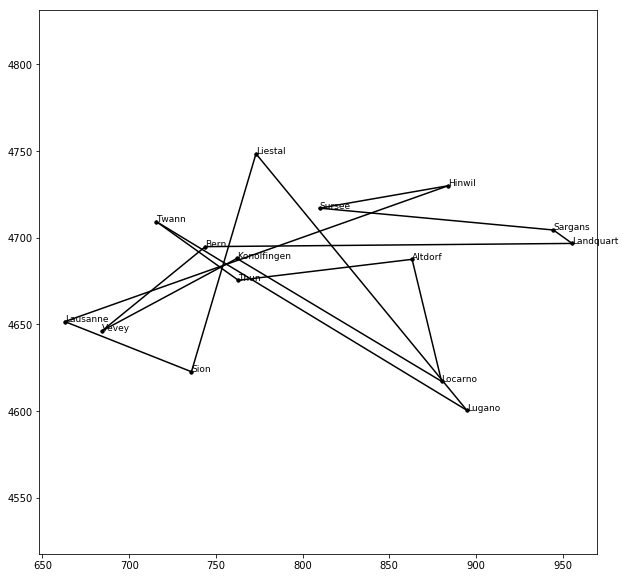

In [15]:
from sbb import SBB

sbb = SBB()
sbb.importData('linie-mit-betriebspunkten.json')

path = {'Sursee', 'Bern', 'Lausanne', 'Liestal', 'Konolfingen', 'Landquart', 'Lugano', 'Vevey', 'Sion', 'Altdorf', 'Hinwil', 'Locarno', 'Sargans', 'Twann', 'Thun'}
plot_path(path, sbb)
print("path cost = " + str(evaluate_path(path, sbb)))

This is defenitly not the best way how to connect the cities. Let's try our first local search algorithm.

### Hill Climbing

If we have 15 cities to connect, we have 15! different possibilities. This is already bigger than 10^12. You can easily see that the problem becomes complex very quickly. We will have problems to systematically explore the search space. Therefore, we will use local search algorithms to tackle this problem.

Local search algorithms start with a solution and try to improve the solution by considering the neighbouring states. The best neighbour will be chosen until no better can be found.

Here, we try to minimize the distance of our path. So instead of hill climbing, we will do the opposite. Instead of trying to find the highest hill (maximum), we're looking at the deepest valley (minimum). But that's not a concern, we can easily change the sign to switch from a maximization  to a minimization problem.

*Hints:*
- use the `evaluate_path()` function we have defined earlier
- make sure to copy lists or sets properly: `current_path = path.copy()`
- you can convert sets to lists by `list(my_set)`
- a neighbouring path can be found by switching the position of two cities

In [18]:
import sys

import sys
from functools import reduce

def swap_neighbours(path, x, y):
    r = path.copy()
    r[x], r[y] = r[y], r[x]
    return r


def generate_neighbour(path):
    possibilities = [[swap_neighbours(path, x, y) for y in range(x, len(path))] for x in range(len(path) - 1)]
    return reduce((lambda x, y: x + y), possibilities)


def hill_climbing_TSP(path, sbb):
    path = list(path)
    score = evaluate_path(path, sbb)
    
    while True:
        neighbours = [(evaluate_path(p, sbb), p) for p in generate_neighbour(list(path))]
        candidate = sorted(neighbours, key=lambda i: i[0])[0]
        
        if candidate[0] < score:
            path = candidate[1]
            score = candidate[0]
        else:
            return path

    return path

with length 865.2893181586151


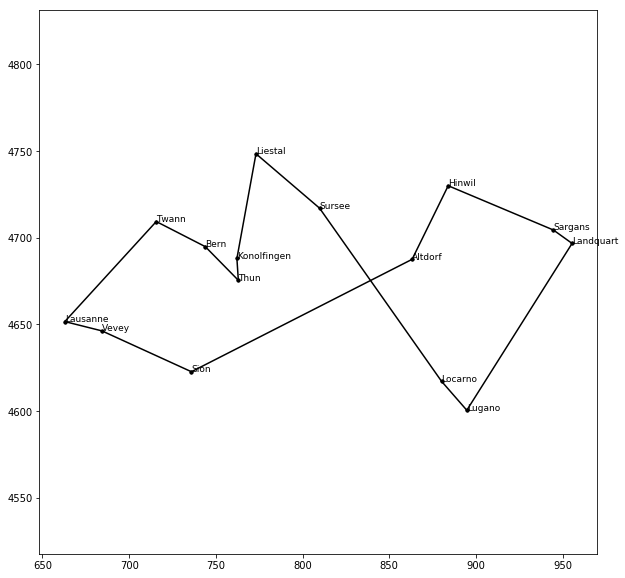

In [19]:
best_path = hill_climbing_TSP(path, sbb)
plot_path(best_path, sbb)
print("with length " + str(evaluate_path(best_path,sbb)))

Oh, what happend here? Is this the best we can get?
- Why is this so? 
- How many steps did we need to get to this solution?
- Can you suggest a method to improve the hill climbing algorithm?

### Genetic Algorithm 

Genetic algorithms (or GA) are inspired by natural evolution and are particularly useful in optimization and search problems with large state spaces.

Given a problem, algorithms in the domain make use of a *population* of solutions (also called *states*), where each solution/state represents a feasible solution. At each iteration (often called *generation*), the population gets updated using methods inspired by biology and evolution, like *crossover*, *mutation* and *natural selection*.

A genetic algorithm works in the following way:

1) Initialize random population.

2) Calculate population fitness.

3) Select individuals for mating.

4) Mate selected individuals to produce new population.

     * Random chance to mutate individuals.

5) Repeat from step 2) until an individual is fit enough or the maximum number of iterations was reached.

Below, you can find some helper functions to implement your genetic algorithm.

First, create a dictionnary that maps a letter to a city name.

Our solution will be a path through all the cities. To simplify, we will encode each city with a letter from the alphabet. So your first initial path through the cities will have the code "ABCDEFGHIJK..". We can easily convert a letter to a city by `letter2city('A')` or `city2letter('Rotkreuz')`.

In [5]:
import string

number_of_cities = len(path)
letter2city = dict()
city2letter = dict()
for i in range(number_of_cities):
    letter2city[string.ascii_uppercase[i]] = list(path)[i]
    city2letter[list(path)[i]] = string.ascii_uppercase[i]
    
def path2string(path):
    s = ""
    for city in path:
        s+=city2letter[city]
    return list(s)

def path2cities(path):
    s = list()
    for letter in path:
        s.append(letter2city[letter])
    return s

path_code = path2string(path)
print("the path has the following code : ")
print(path_code)

the path has the following code : 
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']


Let's inizialize a random population:

In [11]:
import random

def init_population(pop_number, cities):
    """Initializes population for genetic algorithm
    pop_number  :  Number of individuals in population
    cities      :  cities in letter code """



We can calculate the fitness of a path using the evaluate_path function. Note that shorter paths are considered fitter.

In [ ]:
def fitness(sample):


Create a function to select two individuals for mating. Fitter individuals are more likely to be selected for reproduction than less fit individuals. Therefore, we have to calculate the weights of each indiviudal that corresponds to the likelyhood of being chosen for reproduction.

In [42]:
import random
from random import choices


def calculate_weights(population):
    # calculate the weight of each individual
    return


def select(population, weights):
    # return two individuals for reproduction
    # fitter individuals should be more likely to be selected
    # hint: use random.choices to chose from the population based on the weights of each individual
    return

population = init_population(10, path_code)
weights = calculate_weights(population)
print(select(population, weights))

None


Now that we can select two individuals, we make them reproduce using crossover and mutation. We need to consider that we want to visit every city exactly once. For example, for the crossover, you can take a random lenght of individual 1 and fill up the remaining cities based on the order of the unvisited cities in individual 2.

In [47]:
def crossover(x, y):
    # create an offspring from the parents x and y
    return
    
def mutate(x, p_mutate):
    # switch the location of two cities
    return

# test your code
x = path_code
y = random.sample(path_code, len(path_code))
xy = crossover(x,y)
print(x)
print(y)
print(xy)
mutate(xy, 0.5)
print(xy)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']
['I', 'B', 'C', 'N', 'K', 'O', 'A', 'F', 'G', 'M', 'D', 'J', 'L', 'E', 'H']
None
None


We have now all the ingredients to create our genetic algorithm:

### Simulated Annealing

The intuition behind Hill Climbing was developed from the metaphor of climbing up the graph of a function to find its peak. 
There is a fundamental problem in the implementation of the algorithm however.
To find the highest hill, we take one step at a time, always uphill, hoping to find the highest point, 
but if we are unlucky to start from the shoulder of the second-highest hill, there is no way we can find the highest one. 
The algorithm will always converge to the local optimum.
Hill Climbing is also bad at dealing with functions that flatline in certain regions.
If all neighboring states have the same value, we cannot find the global optimum using this algorithm.
<br>
<br>
Let's now look at an algorithm that can deal with these situations.
<br>
Simulated Annealing is quite similar to Hill Climbing, 
but instead of picking the _best_ move every iteration, it picks a _random_ move. 
If this random move brings us closer to the global optimum, it will be accepted, 
but if it doesn't, the algorithm may accept or reject the move based on a probability dictated by the _temperature_. 
When the *temperature* is high, the algorithm is more likely to accept a random move even if it is bad.
At low temperatures, only good moves are accepted, with the occasional exception.
This allows exploration of the state space and prevents the algorithm from getting stuck at the local optimum.

The temperature is gradually decreased over the course of the iteration.
This is done by a scheduling routine:


In [ ]:
def exp_schedule(k=20, lam=0.005, limit=100):
    """One possible schedule function for simulated annealing"""
    return lambda t: (k * math.exp(-lam * t) if t < limit else 0)